# Prediction Model

In [1]:
import os
import json
import gzip
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
from urllib.request import urlopen
from numpy.linalg import norm
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor

import re # regular expressions
from tqdm import tnrange, tqdm_notebook, tqdm
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm

# default plot configurations 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

In [2]:
def dropnested(alist):
    outputdict = {}
    for dic in alist:
        for key, value in dic.items():
            if isinstance(value, dict):
                for k2, v2, in value.items():
                    outputdict[k2] = outputdict.get(k2, []) + [v2]
            else:
                outputdict[key] = outputdict.get(key, []) + [value]
    return outputdict   

In [3]:
def reformat(time):
    year, date = re.findall('(\d+-\d+-\d+)T(\d+:\d+).*', time)[0]
    hour, minute = date.split(":")
    if int(minute) <= 29:
        minute = "00"
    else:
        minute = "30"
        
    return "{} {}:{}".format(year, hour, minute)

In [312]:
def prep_data(input_path, gt_path, mode='train', sent_mean=0):
    data = json.load(open(input_path))
    author_data = pd.json_normalize(data,record_path = ['data'])
    author_data.drop(columns=['geo.place_id'],inplace=True)
    if 'geo.coordinates.type' in author_data.columns:
        author_data.drop(columns=['geo.coordinates.type','geo.coordinates.coordinates'],inplace=True)
    author_data = author_data.rename({"id": "tweet_id"}, axis='columns')
    
    follower_data_raw = data["includes"]["users"]
    follower_data = pd.DataFrame.from_dict(dropnested(follower_data_raw))
    follower_data = follower_data.rename({"id": "author_id"}, axis='columns').drop_duplicates(subset=['author_id'])

    complete_data = author_data.merge(follower_data, on='author_id', how='left').fillna(0)
    complete_data['text'] = complete_data['text'].astype('str')
    
    for i,s in enumerate(tqdm(complete_data['text'])):
        text = complete_data.loc[i, 'text']
        text = text.replace("#", "")
        text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text, flags=re.MULTILINE)
        text = re.sub('@\\w+ *', '', text, flags=re.MULTILINE)
        complete_data.loc[i, 'text'] = text

    analyzer = SentimentIntensityAnalyzer()
    compound = []
    for i,s in enumerate(tqdm(complete_data['text'])):
        vs = analyzer.polarity_scores(s)
        compound.append(vs["compound"])
    complete_data["compound"] = compound
    if mode == "train":
        sent_mean = complete_data['compound'].mean()
        
    complete_data['compound'] -= sent_mean        
    
    complete_data['log_followers_count'] = np.log(complete_data['followers_count']+1)
    complete_data['log_like_count'] = np.log(complete_data['public_metrics.like_count']+1)
    complete_data['log_retweet_count'] = np.log(complete_data['public_metrics.retweet_count']+1)
    
    score1,score2,score3, score4 = [],[],[],[]
    for i, s in tqdm(complete_data.iterrows(), total=complete_data.shape[0]):
        score1.append(s["compound"] * (s["log_like_count"]+1)) # consider number of likes
        score2.append(s["compound"] * (s["log_followers_count"]+1)) # consider number of followers
        score3.append(s["compound"] * (s["log_retweet_count"]+1)) # consider number of retweets 
        score4.append(s["compound"] * (s["log_followers_count"]+1) * (s["log_like_count"]+1) * (s["log_retweet_count"]+1)) # consider all of these 

    complete_data["like_score"] = score1
    complete_data["follower_score"] = score2 
    complete_data["retweet_score"] = score3
    complete_data["overall_score"] = score4
    complete_data['reformat_time'] = complete_data['created_at'].apply(reformat)

    average_score = complete_data.groupby("reformat_time").median()
    selected_features = average_score.loc[:, ["like_score", "follower_score", "retweet_score", "overall_score"]]
    scores = selected_features.to_numpy()
    
    prices = pd.read_csv(gt_path)['price'].to_numpy()
    
    return scores, prices, sent_mean


In [5]:
train_input = 'dataset/train_nft_tweets.json'
train_gt = 'dataset/train_nft_price.csv'
train_score, train_prices, train_sent_mean = prep_data(train_input, train_gt)

100%|██████████████████████████████████| 28733/28733 [00:02<00:00, 10612.92it/s]


In [6]:
test_input = 'dataset/test_nft_tweets.json'
test_gt = 'dataset/test_nft_price.csv'
test_scores, test_prices, _ = prep_data(test_input, test_gt, 'test', train_sent_mean)

100%|████████████████████████████████████| 4797/4797 [00:00<00:00, 10433.63it/s]


In [24]:
def rmse(y1, y2):
    return round(np.sqrt(((y1-y2)**2).mean()),5)

In [25]:
def mae(y1, y2):
    return round(abs(y1-y2).mean(),5)

In [27]:
# predict price using linear reg
X_train = train_score[:-1,:]
y_train = train_prices[1:]
X_test = test_scores[:-1, :]
y_test = test_prices[1:]

reg1 = LinearRegression()
reg1.fit(X_train, y_train)
y_pred_train = reg1.predict(X_train)
y_pred_test = reg1.predict(X_test)

train_RMSE = rmse(y_pred_train,y_train)
test_RMSE = rmse(y_pred_test,y_test)
train_MAE = mae(y_pred_train,y_train)
test_MAE = mae(y_pred_test,y_test)
print("train RMSE: {}, test RMSE: {}".format(train_RMSE, test_RMSE))
print("train MAE: {}, test MAE: {}".format(train_MAE, test_MAE))

train RMSE: 0.02967, test RMSE: 0.05035
train MAE: 0.02385, test MAE: 0.05007


In [28]:
# predict price diff using linear reg
X_train = train_score[:-1, :]
y_train = train_prices[1:] - train_prices[:-1]
X_test = test_scores[:-1, :]
y_test = test_prices[1:] - test_prices[:-1]

reg2 = LinearRegression()
reg2.fit(X_train, y_train)
y_pred_train = reg2.predict(X_train)
y_pred_test = reg2.predict(X_test)

train_RMSE = rmse(y_pred_train,y_train)
test_RMSE = rmse(y_pred_test,y_test)
train_MAE = mae(y_pred_train,y_train)
test_MAE = mae(y_pred_test,y_test)
print("train RMSE: {}, test RMSE: {}".format(train_RMSE, test_RMSE))
print("train MAE: {}, test MAE: {}".format(train_MAE, test_MAE))

train RMSE: 0.00529, test RMSE: 0.00142
train MAE: 0.00128, test MAE: 0.00077


In [29]:
# predict actual price using xgboost
X_train = train_score[:-1,:]
y_train = train_prices[1:]
X_test = test_scores[:-1, :]
y_test = test_prices[1:]

reg3 = XGBRegressor()
reg3.fit(X_train, y_train)
y_pred_train = reg3.predict(X_train)
y_pred_test = reg3.predict(X_test)

train_RMSE = rmse(y_pred_train,y_train)
test_RMSE = rmse(y_pred_test,y_test)
train_MAE = mae(y_pred_train,y_train)
test_MAE = mae(y_pred_test,y_test)
print("train RMSE: {}, test RMSE: {}".format(train_RMSE, test_RMSE))
print("train MAE: {}, test MAE: {}".format(train_MAE, test_MAE))

train RMSE: 0.0166, test RMSE: 0.03155
train MAE: 0.01195, test MAE: 0.0245


In [310]:
len(train_score), len(test_scores)

(288, 48)

In [318]:
# predict price diff using xgboost
X_train = train_score[:-1, :]
y_train = train_prices[1:] - train_prices[:-1]
X_test = test_scores[:-1, :]
y_test = test_prices[1:] - test_prices[:-1]

reg4 = XGBRegressor(max_depth=10)
reg4.fit(X_train, y_train)
y_pred_train = reg4.predict(X_train)
y_pred_test = reg4.predict(X_test)

train_RMSE = rmse(y_pred_train,y_train)
test_RMSE = rmse(y_pred_test,y_test)
train_MAE = mae(y_pred_train,y_train)
test_MAE = mae(y_pred_test,y_test)
print("train RMSE: {}, test RMSE: {}".format(train_RMSE, test_RMSE))
print("train MAE: {}, test MAE: {}".format(train_MAE, test_MAE))

train RMSE: 0.00103, test RMSE: 0.00151
train MAE: 0.00054, test MAE: 0.00072


## K-fold validation

In [345]:
from sklearn.model_selection import KFold
from sklearn.base import clone

def cross_validate_rmse(model):
    model = clone(model)
    five_fold = KFold(n_splits=5)
    rmse_values = []
    for tr_ind, va_ind in five_fold.split(X_train):
        model.fit(X_train[tr_ind], y_train[tr_ind])
        rmse_values.append(rmse(y_train[tr_ind], model.predict(X_train[tr_ind])))
    return np.mean(rmse_values)

def compare_models(models):
    for model in models:
        model.fit(X_train, y_train)
    print(rmse(y_train, model.predict(X_train)))
    val_rmses = []
    for model in tqdm(models):
        val_rmses.append(cross_validate_rmse(model))
    return val_rmses

In [301]:
max_depths = [2,4,6,8,10]
min_child_weights = range(5)
lrs = np.arange(0,1,0.1)
gammas = np.arange(0,0.001,0.0001)
alphas = np.arange(0,0.01,0.002)
lambdas = [1,2,5]
models = []

for md in max_depths:
    for w in min_child_weights:
        for lr in lrs:
            for g in gammas:
                for a in alphas:
                    for l in lambdas:
                        models.append(XGBRegressor(max_depth=md, min_child_weight=w, 
                                   learning_rate=lr, gamma=g, reg_alpha=a, reg_lambda=l))

In [302]:
validation_rmse = compare_models(models)

100%|█████████████████████████████████████| 37500/37500 [24:39<00:00, 25.35it/s]


In [337]:
min(validation_rmse)

0.0008419999999999999

In [303]:
idx = validation_rmse.index(min(validation_rmse))
opt_model = models[idx]
print("max_depth={}, min_child_weight={}, learning_rate={}, gamma={}, alpha={}, lambda={}"
      .format(opt_model.max_depth, opt_model.min_child_weight, 
              opt_model.learning_rate, opt_model.gamma, opt_model.reg_alpha, opt_model.reg_lambda))

max_depth=8, min_child_weight=0, learning_rate=0.9, gamma=0.0, alpha=0.0, lambda=1


In [339]:
opt_model = XGBRegressor(max_depth=8, min_child_weight=0, 
                                   learning_rate=0.9, gamma=0, reg_alpha=0, reg_lambda=1)

In [340]:
opt_model.fit(X_train, y_train)

XGBRegressor(learning_rate=0.9, max_depth=8, min_child_weight=0)

In [341]:
y_pred_train = opt_model.predict(X_train)
y_pred_test = opt_model.predict(X_test)

In [342]:
rmse(y_pred_train, y_train),mae(y_pred_train, y_train)

(0.00094, 0.00052)

In [343]:
rmse(y_pred_test, y_test),mae(y_pred_test, y_test)

(0.00167, 0.00086)

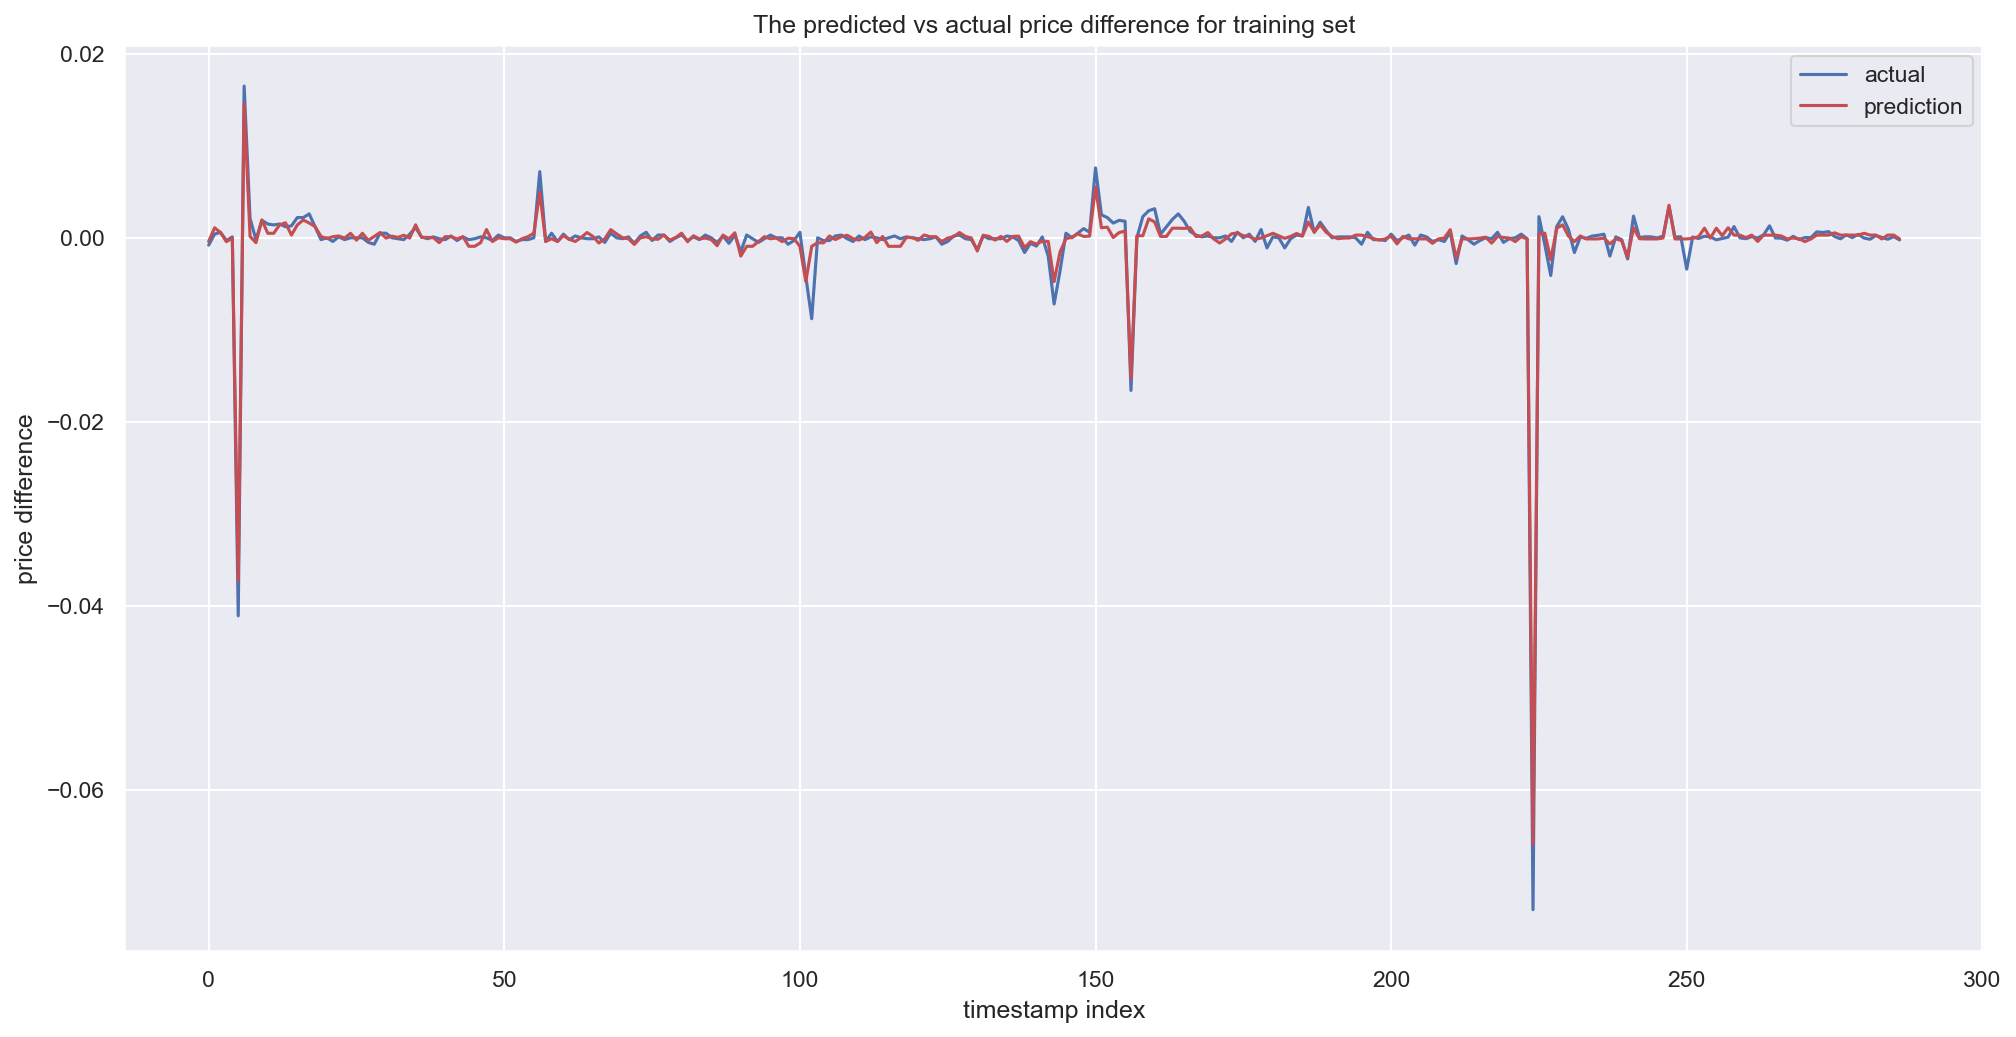

In [335]:
plt.plot(y_train, color="b", label="actual")
plt.plot(y_pred_train, color="r", label="prediction")
plt.xlabel("timestamp index")
plt.ylabel("price difference")
plt.legend()
plt.title("The predicted vs actual price difference for training set");

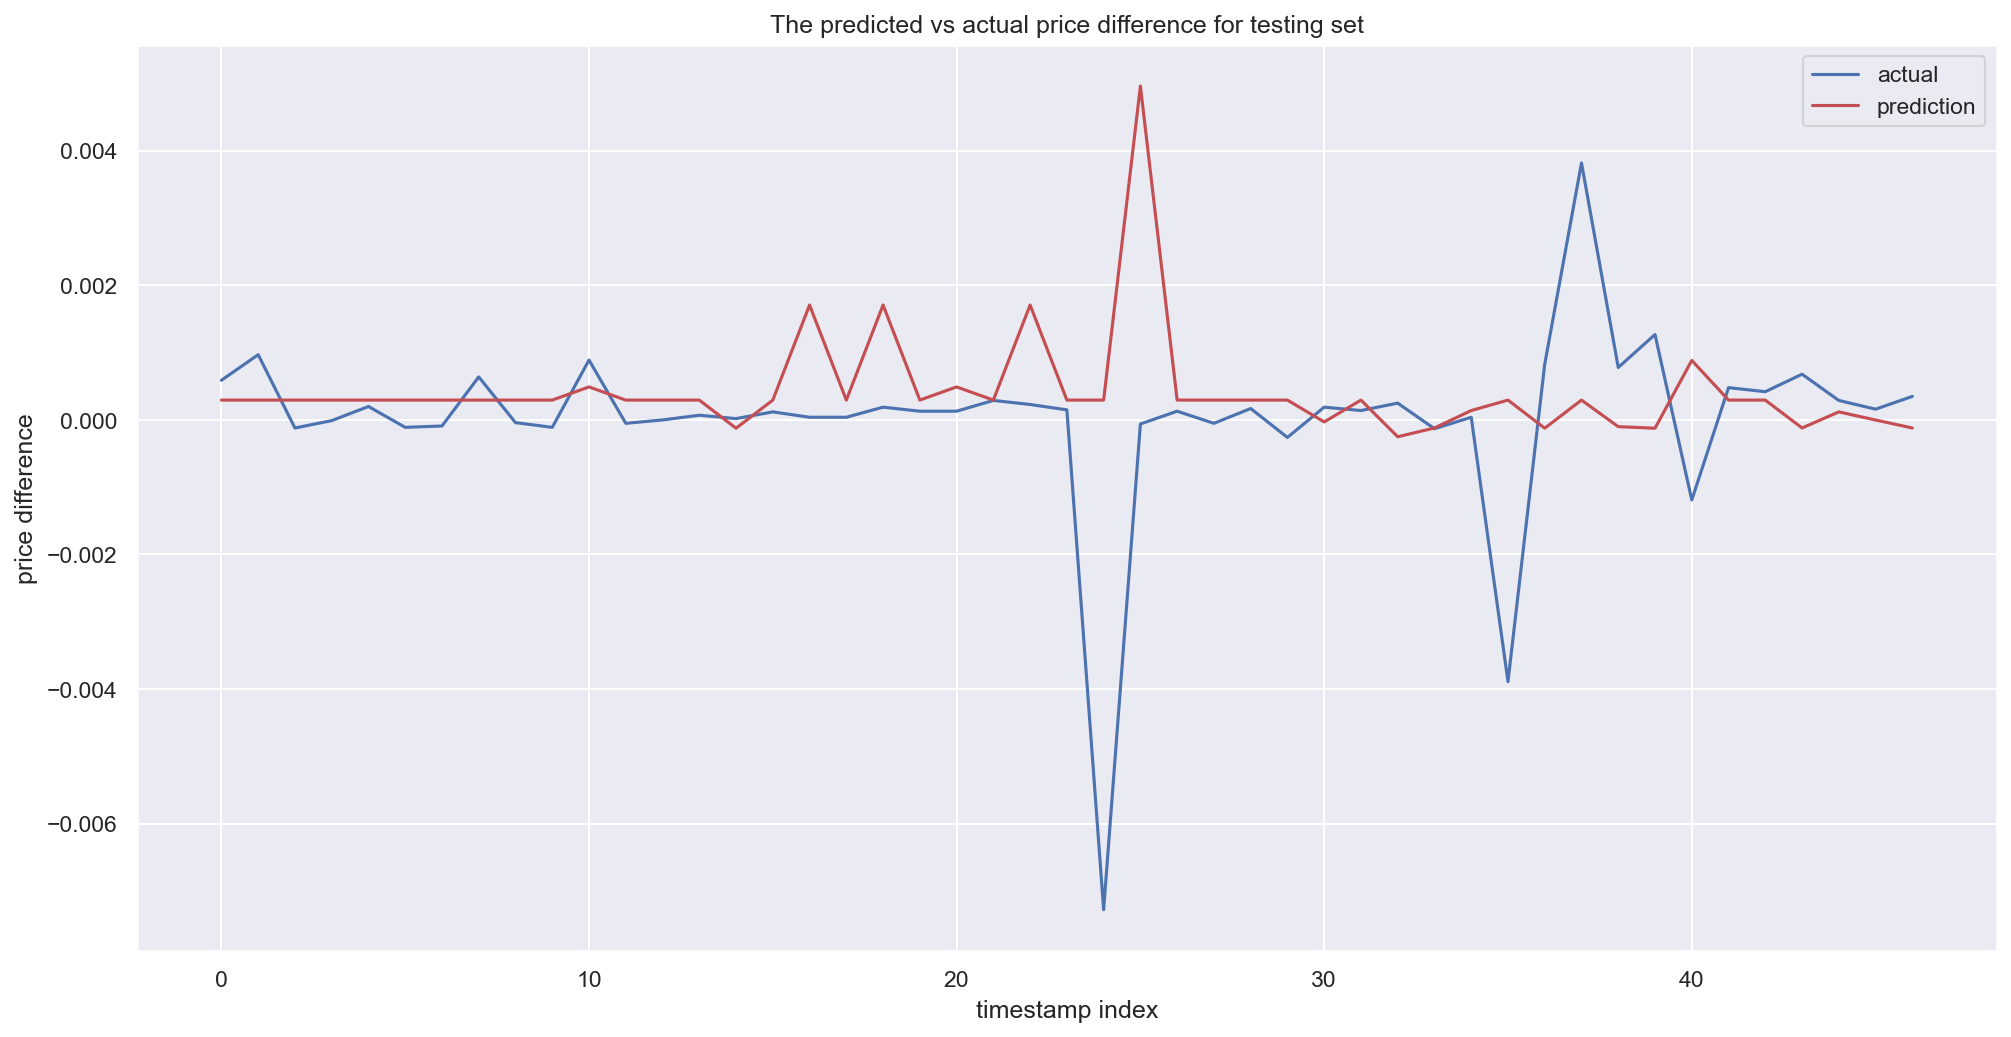

In [336]:
plt.plot(y_test, color="b", label="actual")
plt.plot(y_pred_test, color="r", label="prediction")
plt.xlabel("timestamp index")
plt.ylabel("price difference")
plt.legend()
plt.title("The predicted vs actual price difference for testing set");